In [75]:
import os
# Limit OpenMP to a single thread to prevent potential multithreading conflicts
os.environ["OMP_NUM_THREADS"] = '1'

import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For advanced data visualizations
import matplotlib.pyplot as plt  # For creating plots and visualizations
import matplotlib.ticker as ticker  # For customizing axis ticks in matplotlib
import scipy.optimize as opt  # For optimization tasks, including curve fitting
import errors as err  # Assumes a custom module for handling error propagation
from sklearn.preprocessing import MinMaxScaler  # For scaling features to a specific range
import cluster_tools as ct  # Assumes a custom module for clustering utilities
from sklearn.cluster import KMeans  # For K-Means clustering algorithm
from sklearn.metrics import silhouette_score  # For assessing clustering quality using silhouette score

# Disable warnings about chained assignments in pandas for cleaner output
pd.options.mode.chained_assignment = None


In [76]:
def format_to_k_m(value, position):
    """Convert numbers to 'K' for thousands or 'M' for millions."""
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:
        return f'{value / 1_000:.1f}K'
    else:
        return int(value)


In [77]:
def create_annotated_bar_chart(data, x_column, y_column, chart_title='', x_label='', y_label='', color_palette='coolwarm'):
    """
    Create a bar chart with annotations using seaborn and matplotlib.

    Args:
    data (pandas.DataFrame): DataFrame containing the data to plot.
    x_column (str): Name of the column for the x-axis.
    y_column (str): Name of the column for the y-axis.
    chart_title (str, optional): Title of the bar chart.
    x_label (str, optional): Label for the x-axis.
    y_label (str, optional): Label for the y-axis.
    color_palette (str, optional): Color palette for the bars.
    """
    # Set up the plot dimensions
    plt.figure(figsize=(10, 6))

    # Set plot style
    sns.set(style='whitegrid')  # Change the style to white grid

    # Create a bar plot
    barplot = sns.barplot(x=x_column, y=y_column, data=data, palette=color_palette)

    # Format the y-axis values to use 'K' for thousands and 'M' for millions
    barplot.yaxis.set_major_formatter(ticker.FuncFormatter(format_to_k_m))

    # Annotate each bar with its value
    for bar in barplot.patches:
        barplot.annotate(format_to_k_m(bar.get_height(), None),  # Display formatted value
                         (bar.get_x() + bar.get_width() / 2., bar.get_height()),  # Position above the bar
                         ha='center', va='center',  # Center alignment
                         xytext=(0, 10),  # Offset text slightly above the bar
                         textcoords='offset points')

    # Set axis labels and chart title
    plt.xlabel(x_label)  # Label for the x-axis
    plt.ylabel(y_label)  # Label for the y-axis
    plt.title(chart_title)  # Title of the bar chart

    # Save the chart as a PNG file
    plt.savefig('Bar.png', dpi=300)

    # Display the plot
    plt.show()


In [78]:
def create_correlation_heatmap(dataframe, plot_title='Correlation Matrix', colormap='coolwarm', display_values=True, figure_size=(10, 8)):
    """
    Plot the correlation matrix for the given DataFrame.

    Args:
    dataframe (pandas.DataFrame): The DataFrame whose correlation matrix will be plotted.
    plot_title (str, optional): Title of the heatmap.
    colormap (str, optional): Colormap for the heatmap.
    display_values (bool, optional): Whether to show the correlation coefficients in the plot.
    figure_size (tuple, optional): Figure size as (width, height).
    """
    # Compute the correlation matrix
    correlation_matrix = dataframe.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=figure_size)
    sns.set(style='ticks')  # Set plot style to ticks for a cleaner look

    # Create the heatmap
    heatmap = sns.heatmap(correlation_matrix, annot=display_values, fmt=".2f", cmap=colormap,
                          cbar_kws={'shrink': .5}, linewidths=.5, square=True)

    # Configure tick labels for better readability
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

    # Add plot title
    plt.title(plot_title)

    # Save the plot as a PNG file
    plt.savefig('correlation_heatmap.png', dpi=300)

    # Display the plot
    plt.show()


In [79]:
def plot_scatter_chart(data, x_axis, y_axis, include_regression=False, chart_title='', x_label='', y_label='', point_color='blue', point_marker='o', figure_dimensions=(8, 6)):
    """
    Create a scatter plot of two variables from a DataFrame, with an optional regression line.

    Args:
    data (pandas.DataFrame): The DataFrame containing the data.
    x_axis (str): Column name for the x-axis.
    y_axis (str): Column name for the y-axis.
    include_regression (bool, optional): If True, include a regression line in the plot.
    chart_title (str, optional): Title of the scatter plot.
    x_label (str, optional): Label for the x-axis.
    y_label (str, optional): Label for the y-axis.
    point_color (str, optional): Color of the plot points.
    point_marker (str, optional): Marker style of the plot points.
    figure_dimensions (tuple, optional): Figure size as (width, height).
    """
    # Set up the plot dimensions and style
    plt.figure(figsize=figure_dimensions)
    sns.set(style='whitegrid')  # Setting a cleaner white grid style

    # Scatter plot with or without regression line
    if include_regression:
        sns.regplot(x=x_axis, y=y_axis, data=data, scatter_kws={'color': point_color, 'marker': point_marker})
    else:
        plt.scatter(data[x_axis], data[y_axis], color=point_color, marker=point_marker)

    # Add plot labels and title
    plt.title(chart_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Save the scatter plot as a PNG file
    plt.savefig('scatter_chart.png', dpi=300)

    # Display the plot
    plt.show()


In [80]:
def visualize_silhouette_scores(data, max_clusters=10):
    """
    Compute and plot silhouette scores for varying numbers of clusters.

    Parameters:
    - data: The dataset to be clustered.
    - max_clusters: The maximum number of clusters to evaluate.

    Returns:
    None. Displays a silhouette score plot.
    """

    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        # Perform clustering using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the silhouette scores
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', color='blue')
    plt.title('Silhouette Analysis for Cluster Counts')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.savefig('silhouette_analysis.png', dpi=300)
    plt.show()


In [81]:
def restructure_data_for_bar_chart(columns, dataframe_index, dataframe_list, target_year):
    """
    Extract and restructure data for a specific year for bar chart visualization.

    This function selects a dataframe from a list by index, filters for specific columns and the given year,
    transposes the dataframe, and prepares it for bar chart plotting.

    Parameters:
    - columns (list of str): Column names to retain for the bar chart.
    - dataframe_index (int): Index of the dataframe in the list to process.
    - dataframe_list (list of pandas.DataFrame): List containing the dataframes to process.
    - target_year (str): The year for which the data is retrieved.

    Returns:
    - pandas.DataFrame: A transposed DataFrame with the selected year's data ready for bar chart plotting.
    """
    df = dataframe_list[dataframe_index]
    df = df[columns]
    df = df[df['Year'] == target_year]
    transposed_df = df.T
    transposed_df.columns = df.Year
    transposed_df = transposed_df.astype(float)
    return transposed_df


In [82]:
def process_data_for_heatmap(indicators, dataframes, target_country):
    """
    Process and structure data for heatmap visualization for a specific country.

    Parameters:
    - indicators : list of str
        Names of indicators with optional details in parentheses.
    - dataframes : list of pandas.DataFrame
        DataFrames containing data for indicators.
    - target_country : str
        The country for which data is extracted.

    Returns:
    - pandas.DataFrame
        Processed data ready for heatmap visualization.
    """
    processed_data = {}
    for i, indicator in enumerate(indicators):
        data = dataframes[i]
        data = data[target_country]
        column_means = data.mean()
        data = data.fillna(column_means)
        processed_data[indicator.split('(')[0].strip()] = data.tolist()
    heatmap_df = pd.DataFrame(processed_data)

    return heatmap_df


In [84]:
def cluster_and_visualize(df, x_feature, y_feature, x_label, y_label, plot_title, n_clusters, scaled_data, min_values, max_values, new_points, new_points_df):
    """
    Perform KMeans clustering, plot clusters, and annotate cluster centers.

    Parameters:
    - df : pandas.DataFrame
        Original dataset containing the data points.
    - x_feature, y_feature : str
        Column names in 'df' used for the x and y axes of the plot.
    - x_label, y_label : str
        Labels for the x and y axes of the plot.
    - plot_title : str
        Title of the plot.
    - n_clusters : int
        Number of cluster centers for KMeans clustering.
    - scaled_data : pandas.DataFrame
        Dataset used to fit the KMeans model.
    - min_values, max_values : numpy.array
        Arrays containing the minimum and maximum values used for data scaling.
    - new_points : numpy.array
        New data points to be predicted by the KMeans model.
    - new_points_df : pandas.DataFrame
        DataFrame containing new data points for plotting.

    Returns:
    None. Generates and displays a scatter plot and saves it as a PNG file.

    Notes:
    - The 'ct.backscale' function is assumed to rescale the cluster centers back to their original scale.
    - The plot includes scatter plots for original data, new data, and cluster centers.
    - Each cluster center is annotated with its respective group number directly on the plot.
    """
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    kmeans.fit(scaled_data)  # Fit model on scaled data

    # Extract labels and cluster centers from the fitted model
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Prepare plot
    plt.figure(figsize=(8, 8))

    # Scatter plot for original data
    original_scatter = plt.scatter(df[x_feature], df[y_feature], c=labels, cmap="tab10", label='Original Data')

    # Predict clusters for new data and plot
    new_labels = kmeans.predict(new_points)  # Predicting clusters for new data
    new_data_scatter = plt.scatter(new_points_df[x_feature], new_points_df[y_feature], c=new_labels, cmap="tab10", marker="s", label='New Data')

    # Rescale and show cluster centers
    rescaled_centers = ct.backscale(centers, min_values, max_values)  # Rescale cluster centers
    xc = rescaled_centers[:, 0]
    yc = rescaled_centers[:, 1]
    centers_scatter = plt.scatter(xc, yc, c="k", marker="d", s=80, label='Cluster Centers')  # Black diamonds for cluster centers

    # Annotate cluster centers with group numbers
    for i, (x, y) in enumerate(zip(xc, yc)):
        plt.annotate(f'Group {i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Add legend, labels, title, and save the plot
    plt.legend(handles=[original_scatter, new_data_scatter, centers_scatter], title="Clusters")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.savefig('Clustering_plot.png', dpi=300)
    plt.show()


In [85]:
def forecast_with_polynomial_model(data, country, indicator, fit_plot_title, forecast_plot_title, initial_parameters):
    """
    Fit a polynomial model to the data for a specified country and predict future values.

    Parameters:
    - data : pandas.DataFrame
        Data containing the population (or other indicator) indexed by year.
    - country : str
        The name of the country to analyze (column name in `data`).
    - indicator : str
        Indicator name for the y-axis label.
    - fit_plot_title : str
        Title for the fitting plot.
    - forecast_plot_title : str
        Title for the forecast plot.
    - initial_parameters : list or tuple
        Initial guess for polynomial model parameters.

    Outputs:
    - Saves two plots as PNG files:
        1. `{country}_fit.png`: Polynomial fit plot.
        2. `{country}_forecast.png`: Forecast plot with error bounds.
    """
    # Polynomial model function
    def polynomial(x, a, b, c):
        return a + b * x + c * x**2

    # Fit the model
    popt, pcorr = opt.curve_fit(polynomial, data.index, data[country], p0=initial_parameters)
    data["polynomial_fit"] = polynomial(data.index, *popt)

    # Plot the fitted data
    plt.figure()
    plt.plot(data.index, data[country], label="Data")
    plt.plot(data.index, data["polynomial_fit"], label="Fit")
    plt.legend()
    plt.xlabel('Years')
    plt.ylabel(indicator)
    plt.title(fit_plot_title)
    plt.savefig(f"{country}_fit.png", dpi=300)

    # Prepare for forecast plotting
    years = np.linspace(data.index.min(), 2030)
    polynomial_forecast = polynomial(years, *popt)
    forecast_error = err.error_prop(years, polynomial, popt, pcorr)
    lower_bound = polynomial_forecast - forecast_error
    upper_bound = polynomial_forecast + forecast_error

    # Plot the forecast with error ranges
    plt.figure()
    plt.title(forecast_plot_title)
    plt.plot(data.index, data[country], label="Data")
    plt.plot(years, polynomial_forecast, label="Forecast")
    plt.fill_between(years, lower_bound, upper_bound, alpha=0.5, color="y")
    plt.legend(loc="upper left")
    plt.xlabel('Years')
    plt.ylabel(indicator)
    plt.savefig(f"{country}_forecast.png", dpi=300)
    plt.show()


In [86]:
def refine_indicator_data(dataframe, indicator_list):
    """
    Refine and organize data for specified indicators from a DataFrame.

    Parameters:
    - dataframe : pandas.DataFrame
        Input DataFrame containing an 'Indicator Name' column and yearly data.
    - indicator_list : list of str
        List of indicators to filter and process.

    Returns:
    - list of pandas.DataFrame
        A list of DataFrames, each corresponding to a specified indicator, with years as rows and values as columns.
    """
    processed_dataframes = []
    for indicator in indicator_list:
        data = dataframe[dataframe['Indicator Name'] == indicator]
        data = data.drop('Indicator Name', axis=1)
        data = data.T
        data.columns = data.iloc[0]
        data = data.drop(['Country Name'])
        data = data.astype(float)
        data['Year'] = data.index
        data = data.reset_index(drop=True)
        processed_dataframes.append(data)

    return processed_dataframes


In [87]:
def extract_country_data(dataframe, target_country, start_year, end_year):
    """
    Extract and filter data for a specific country within a specified year range.

    Parameters:
    - dataframe (pandas.DataFrame):
        Input DataFrame containing 'Year' and country-specific data.
    - target_country (str):
        Name of the country column to extract data for.
    - start_year (int):
        Start year for filtering.
    - end_year (int):
        End year for filtering.

    Returns:
    - pandas.DataFrame:
        Filtered DataFrame indexed by 'Year' with data for the specified country and time frame.
    """
    filtered_data = dataframe[['Year', target_country]]
    filtered_data['Year'] = filtered_data['Year'].astype(int)
    filtered_data = filtered_data[(filtered_data['Year'] >= start_year) & (filtered_data['Year'] <= end_year)]
    filtered_data = filtered_data.fillna(0)
    filtered_data = filtered_data.set_index('Year')
    return filtered_data


In [88]:
indicators_to_analyze = ["Agricultural land (sq. km)", "Population, total", "Forest area (sq. km)", "CO2 emissions (kt)", "Urban population", 'Foreign direct investment, net inflows (% of GDP)']
climate_data = pd.read_csv('/content/drive/MyDrive/Datasets/World_Climate data.csv', skiprows=4)
climate_data = climate_data[climate_data['Indicator Name'].isin(indicators_to_analyze)]
climate_data = climate_data.drop(['Country Code', 'Indicator Code', 'Unnamed: 67'], axis=1)
processed_data_frames = refine_indicator_data(climate_data, indicators_to_analyze)


<ipython-input-77-0a56c7802d8f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x_column, y=y_column, data=data, palette=color_palette)


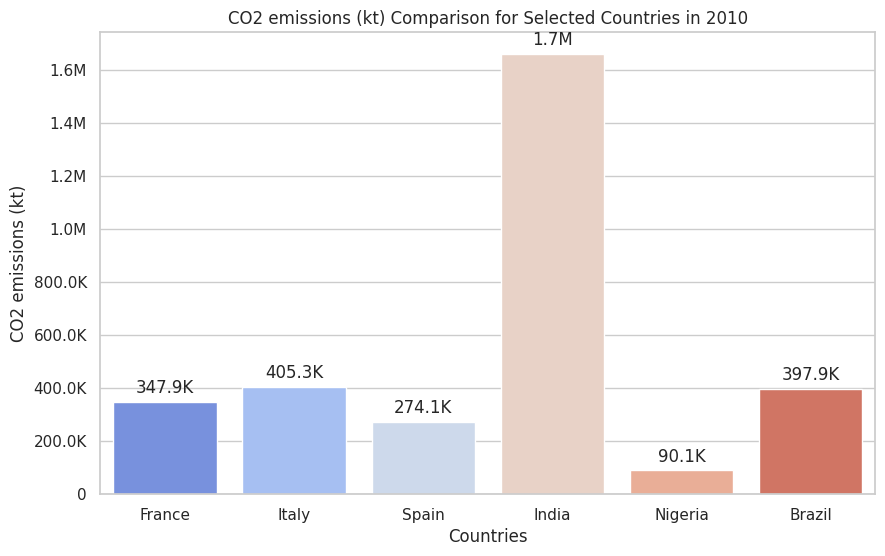

In [89]:
countries = ['France', 'Italy', 'Spain', 'India', 'Nigeria', 'Brazil', 'Year']
bar_2010 = restructure_data_for_bar_chart(countries, 3, processed_data_frames, '2010')
bar_2015 = restructure_data_for_bar_chart(countries, 3, processed_data_frames, '2015')
create_annotated_bar_chart(bar_2010.iloc[:-1], bar_2010.index[:-1], '2010', 'CO2 emissions (kt) Comparison for Selected Countries in 2010', 'Countries', 'CO2 emissions (kt)')


<ipython-input-77-0a56c7802d8f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=x_column, y=y_column, data=data, palette=color_palette)


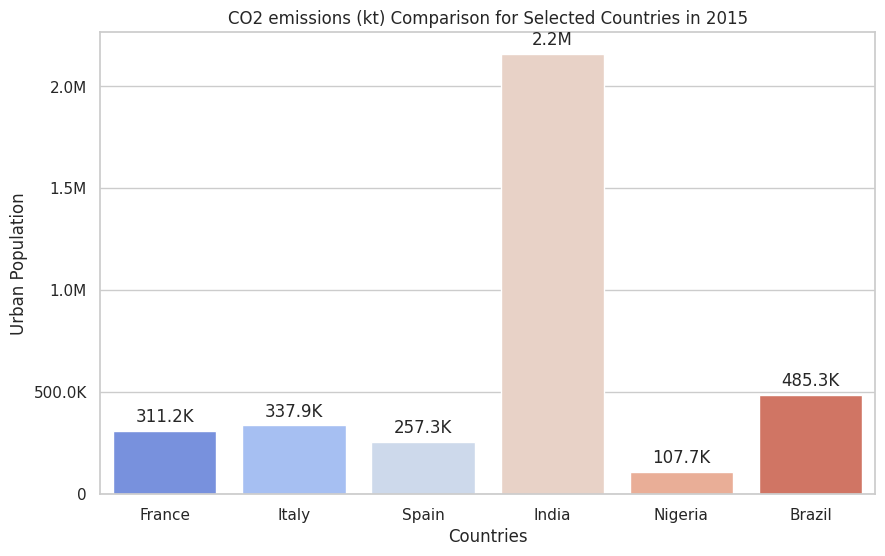

In [90]:
create_annotated_bar_chart(
    bar_2015.iloc[:-1],
    bar_2015.index[:-1],
    '2015',
    'CO2 emissions (kt) Comparison for Selected Countries in 2015',
    'Countries',
    'Urban Population'
)


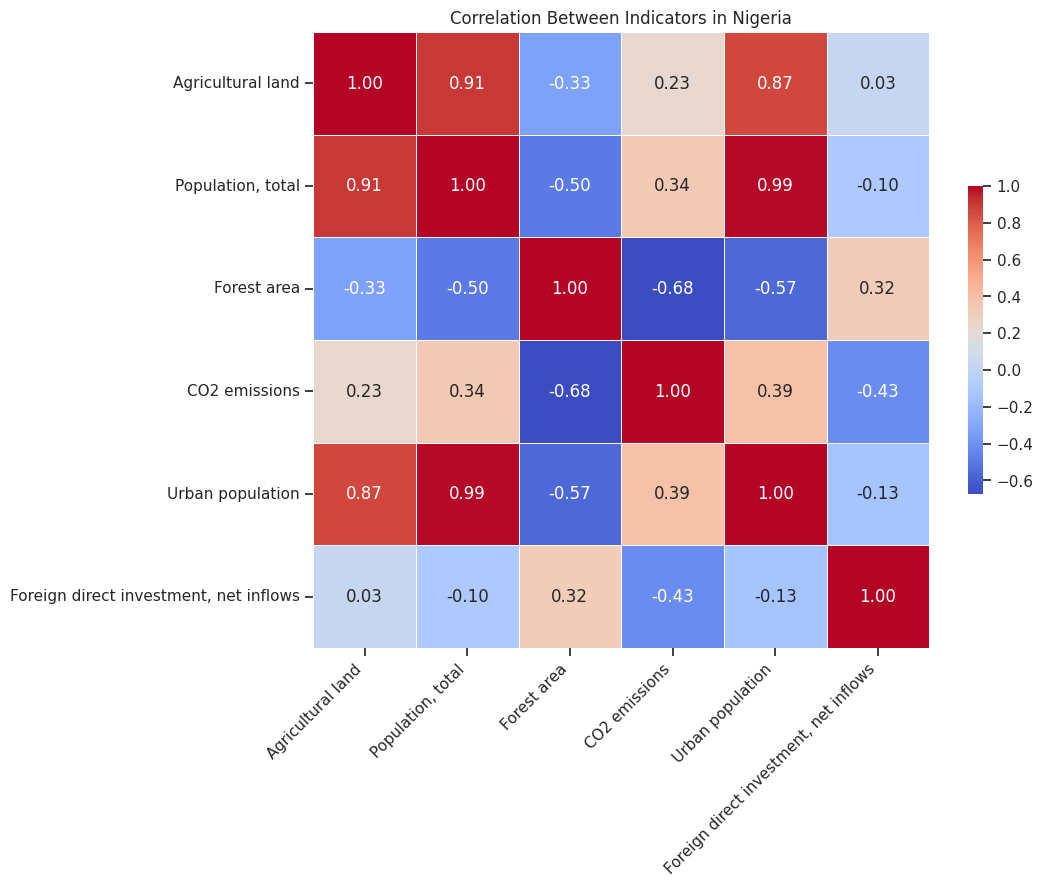

In [91]:
df = process_data_for_heatmap(indicators_to_analyze, processed_data_frames, 'Nigeria')
create_correlation_heatmap(df, 'Correlation Between Indicators in Nigeria')


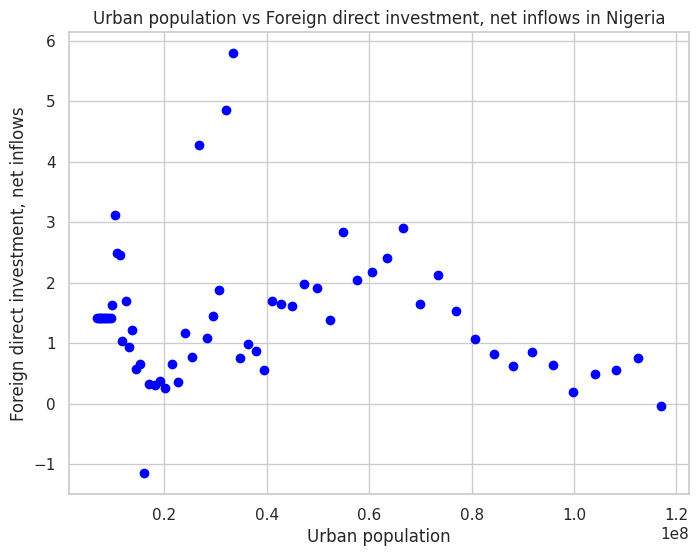

In [92]:
plot_scatter_chart(
    df,
    'Urban population',
    'Foreign direct investment, net inflows',
    include_regression=False,
    chart_title='Urban population vs Foreign direct investment, net inflows in Nigeria',
    x_label='Urban population',
    y_label='Foreign direct investment, net inflows'
)


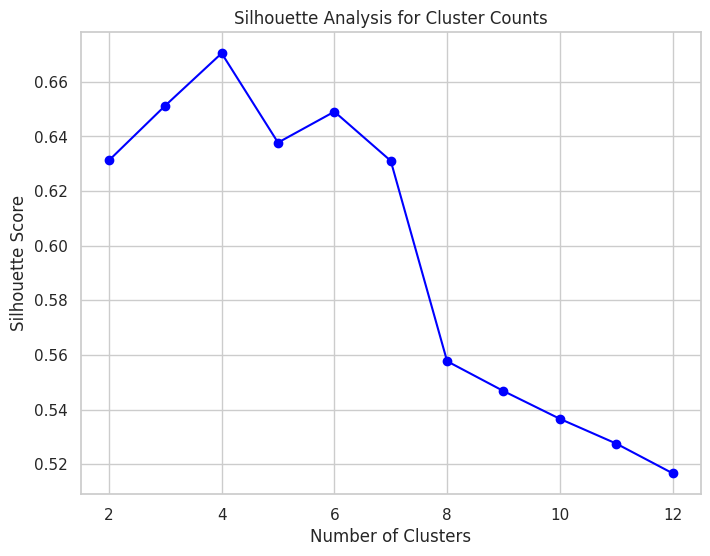

In [93]:
df_selected = df[['Urban population', 'Forest area']]
train_df = df.sample(frac=0.9, random_state=42)  # Random state for reproducibility
test_df = df.drop(train_df.index)
scaled_df, df_min, df_max = ct.scaler(df_selected)
train_scaled_df = scaled_df.sample(frac=0.9, random_state=42)  # Random state for reproducibility
test_scaled_df = scaled_df.drop(train_df.index)

visualize_silhouette_scores(scaled_df, max_clusters=12)


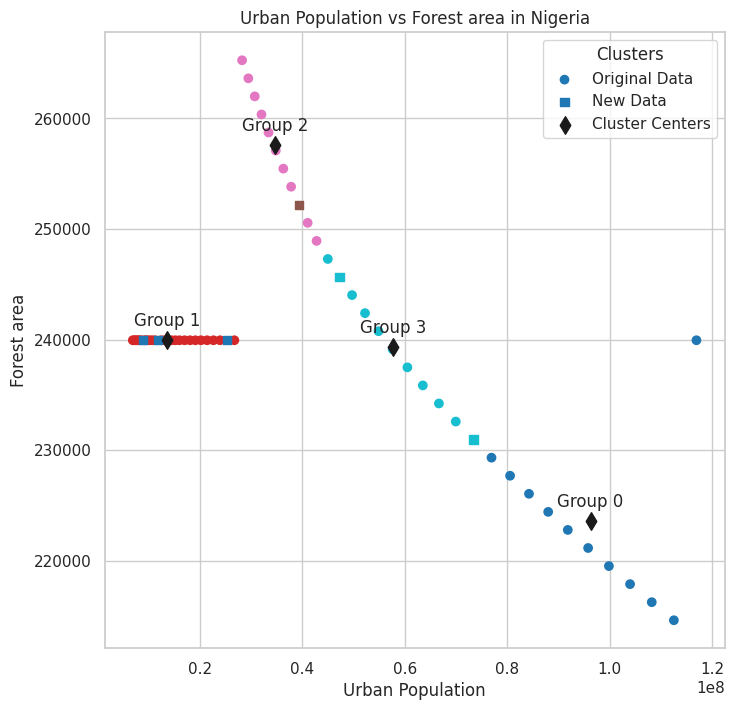

In [94]:
cluster_and_visualize(
    train_df,
    'Urban population',
    'Forest area',
    'Urban Population',
    'Forest area',
    'Urban Population vs Forest area in Nigeria',
    4,
    train_scaled_df,
    df_min,
    df_max,
    test_scaled_df,
    test_df
)


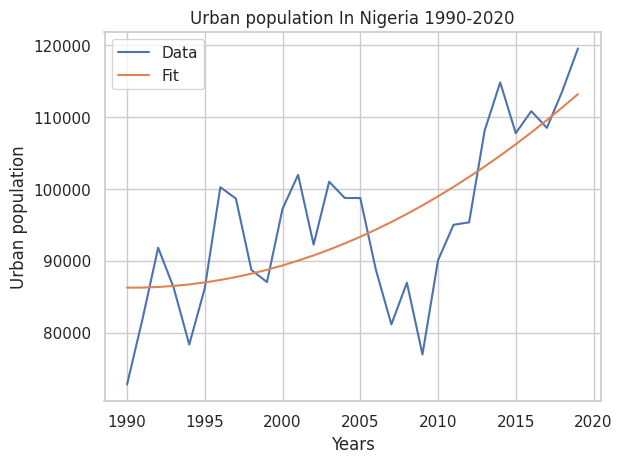

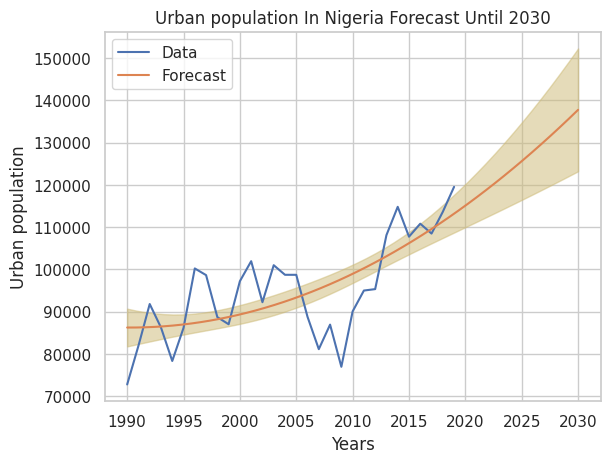

In [95]:
forecast_with_polynomial_model(
    extract_country_data(processed_data_frames[3], 'Nigeria', 1990, 2019),
    'Nigeria',
    'Urban population',
    "Urban population In Nigeria 1990-2020",
    "Urban population In Nigeria Forecast Until 2030",
    (1e5, -50, 1)
)